# Лекция 5: Transformer архитектура и дълъг контекст

**Продължителност:** 2-2.5 часа  
**Предпоставки:** Лекция 4 (Attention механизми)  
**Следваща лекция:** Foundation Models и Pretraining Data

---
## Цели на лекцията

След тази лекция ще можете:

- Разбирате пълната структура на transformer блок (FFN, residuals, layer norm)
- Обяснявате разликите между encoder и decoder архитектури
- Имплементирате GQA и разбирате ефективността на KV cache
- Обяснявате RoPE и защо е важен за дълъг контекст
- Разбирате как моделите обработват 100K-1M+ токена

### Пътна карта

```
1. Recap → 2. Transformer Block → 3. Stacking Layers → 4. Encoder vs Decoder
                                                              ↓
    8. Обобщение ← 7. Цялостна архитектура ← 6. Long Context ← 5. Modern Attention
```

In [1]:
# Основни библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Настройки
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

# Възпроизводимост
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print("Библиотеките са заредени успешно.")

PyTorch version: 2.9.1
Библиотеките са заредени успешно.


---
## 1. Recap и мотивация

### Какво научихме в Лекция 4

| Концепция | Описание |
|-----------|----------|
| **Self-Attention** | Всяка позиция "вижда" всяка друга |
| **Q, K, V** | Query търси, Key идентифицира, Value съдържа |
| **Scaled Dot-Product** | $\text{Attention} = \text{softmax}(QK^T / \sqrt{d_k})V$ |
| **Multi-Head** | Множество паралелни attention patterns |
| **Positional Encodings** | Добавят информация за реда |

### Какво липсва?

Multi-head attention е **ядрото**, но не е достатъчно:

- Как се стекват слоеве?
- Какво още има в transformer блок?
- Как от 512 токена стигаме до 1M?

**Тази лекция:** Пълна transformer архитектура + модерни оптимизации.

---
## 2. Пълният Transformer блок

### Архитектура на блока

```
Input
  ↓
Layer Norm
  ↓
Multi-Head Self-Attention
  ↓ (+) Residual Connection
Layer Norm
  ↓
Feed-Forward Network
  ↓ (+) Residual Connection
Output
```

Нека разгледаме всеки компонент.

### Feed-Forward Network (FFN)

Две линейни трансформации с нелинейност между тях:

$$\text{FFN}(x) = W_2 \cdot \text{GELU}(W_1 x + b_1) + b_2$$

**Размерности:**
- Вход: $d_{model}$
- Скрит слой: $4 \times d_{model}$ (типично)
- Изход: $d_{model}$

In [2]:
# Пример: GPT-2 размерности
d_model = 768
d_ff = 4 * d_model  # 3072

print(f"GPT-2 FFN: {d_model} → {d_ff} → {d_model}")
print(f"Параметри: {d_model * d_ff + d_ff + d_ff * d_model + d_model:,}")

GPT-2 FFN: 768 → 3072 → 768
Параметри: 4,722,432


### Защо FFN?

| Attention | FFN |
|-----------|-----|
| Смесва информация **между** позиции | Обработва всяка позиция **независимо** |
| Линейна операция (без activation) | Добавя нелинейност |
| "Комуникация" | "Изчисление" |

**Интересно откритие:** FFN слоевете съхраняват фактически знания!

In [3]:
class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network."""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        x = self.linear1(x)         # → [batch, seq_len, d_ff]
        x = F.gelu(x)               # Нелинейност
        x = self.dropout(x)
        x = self.linear2(x)         # → [batch, seq_len, d_model]
        return x

# Тест
ffn = FeedForward(d_model=64, d_ff=256)
x = torch.randn(2, 10, 64)
print(f"Input: {x.shape} → Output: {ffn(x).shape}")

Input: torch.Size([2, 10, 64]) → Output: torch.Size([2, 10, 64])


### Activation функции

| Функция | Формула | Използва се от |
|---------|---------|----------------|
| ReLU | $\max(0, x)$ | Original Transformer |
| GELU | $x \cdot \Phi(x)$ | GPT, BERT |
| SwiGLU | $\text{Swish}(xW_1) \odot xV$ | LLaMA, Mistral |

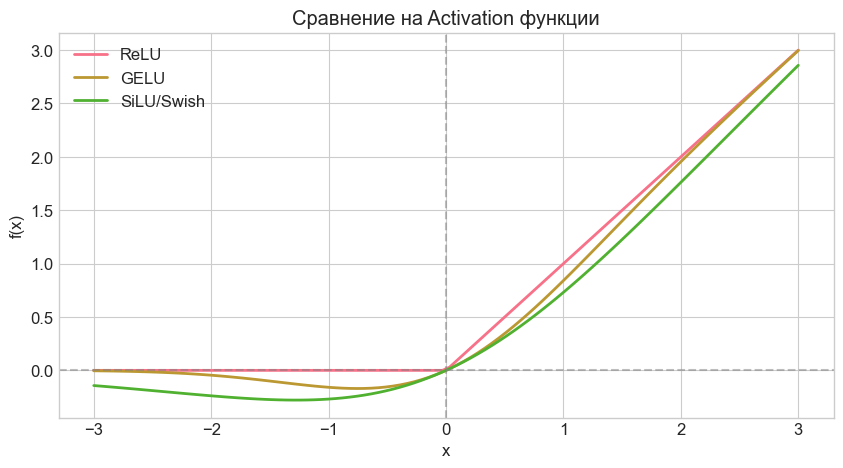

GELU и SiLU са 'гладки' версии на ReLU.


In [4]:
# Сравнение на activation функции
x = torch.linspace(-3, 3, 100)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x.numpy(), F.relu(x).numpy(), label='ReLU', linewidth=2)
ax.plot(x.numpy(), F.gelu(x).numpy(), label='GELU', linewidth=2)
ax.plot(x.numpy(), F.silu(x).numpy(), label='SiLU/Swish', linewidth=2)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('x'); ax.set_ylabel('f(x)')
ax.set_title('Сравнение на Activation функции')
ax.legend()
plt.show()

print("GELU и SiLU са 'гладки' версии на ReLU.")

### SwiGLU: Модерна алтернатива

Използва се от LLaMA, Mistral, повечето модерни модели:

$$\text{SwiGLU}(x) = \text{Swish}(xW_1) \odot (xV)$$

**Gated Linear Unit:** Част от входа контролира "врата".

In [5]:
class SwiGLU(nn.Module):
    """SwiGLU activation (LLaMA-style FFN)."""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)  # Gate
    
    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

# Тест
swiglu = SwiGLU(d_model=64, d_ff=256)
x = torch.randn(2, 10, 64)
print(f"SwiGLU: {x.shape} → {swiglu(x).shape}")

SwiGLU: torch.Size([2, 10, 64]) → torch.Size([2, 10, 64])


### Residual Connections (Skip Connections)

$$\text{output} = x + \text{Sublayer}(x)$$

**Защо са критични?**

- Позволяват обучение на дълбоки мрежи (96+ слоя)
- Директен път за градиента от изход към вход
- Слоевете научават "подобрения", не цялата трансформация

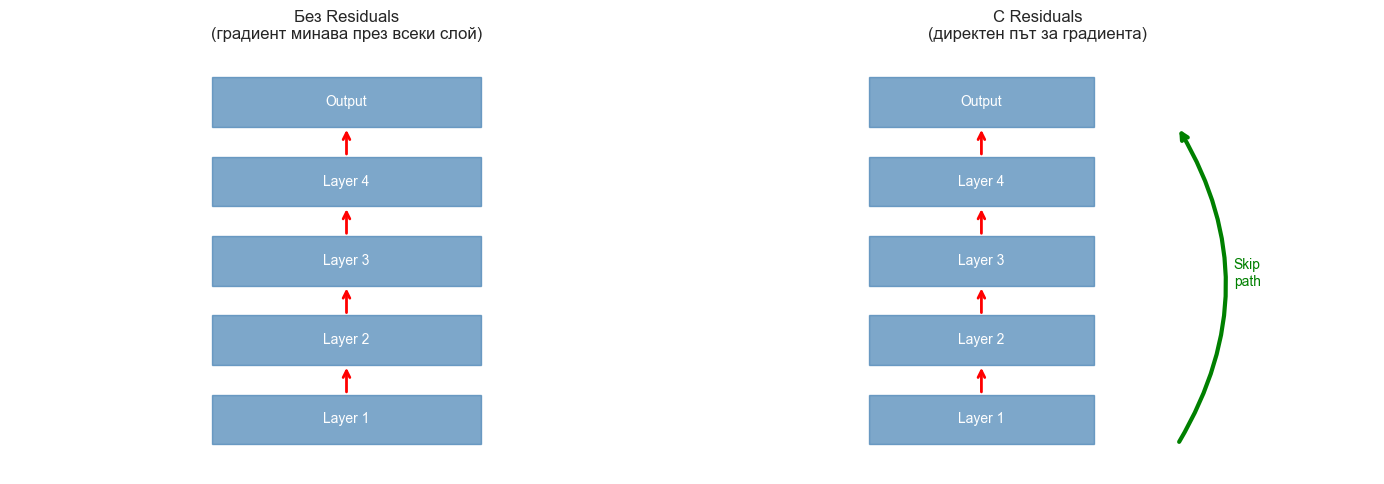

In [6]:
# Визуализация: Gradient flow с и без residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Без residuals
ax = axes[0]
layers = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Output']
for i, layer in enumerate(layers):
    ax.add_patch(plt.Rectangle((0.3, i*0.8), 0.4, 0.5, 
                               fill=True, color='steelblue', alpha=0.7))
    ax.text(0.5, i*0.8 + 0.25, layer, ha='center', va='center', 
            fontsize=10, color='white')
    if i < len(layers) - 1:
        ax.annotate('', xy=(0.5, (i+1)*0.8), xytext=(0.5, i*0.8 + 0.5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.set_xlim(0, 1); ax.set_ylim(-0.3, 4)
ax.axis('off')
ax.set_title('Без Residuals\n(градиент минава през всеки слой)', fontsize=12)

# С residuals
ax = axes[1]
for i, layer in enumerate(layers):
    ax.add_patch(plt.Rectangle((0.3, i*0.8), 0.4, 0.5, 
                               fill=True, color='steelblue', alpha=0.7))
    ax.text(0.5, i*0.8 + 0.25, layer, ha='center', va='center', 
            fontsize=10, color='white')
    if i < len(layers) - 1:
        ax.annotate('', xy=(0.5, (i+1)*0.8), xytext=(0.5, i*0.8 + 0.5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Skip connections
ax.annotate('', xy=(0.85, 3.2), xytext=(0.85, 0.0),
            arrowprops=dict(arrowstyle='->', color='green', lw=3, 
                           connectionstyle='arc3,rad=0.3'))
ax.text(0.95, 1.6, 'Skip\npath', fontsize=10, color='green', ha='left')

ax.set_xlim(0, 1.2); ax.set_ylim(-0.3, 4)
ax.axis('off')
ax.set_title('С Residuals\n(директен път за градиента)', fontsize=12)

plt.tight_layout()
plt.show()

### Layer Normalization

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sigma + \epsilon} + \beta$$

- $\mu, \sigma$ се изчисляват по **feature** измерението (за всяка позиция)
- $\gamma, \beta$ са научени параметри

### Защо LayerNorm, а не BatchNorm?

| BatchNorm | LayerNorm |
|-----------|----------|
| Нормализира по batch измерение | Нормализира по feature измерение |
| Зависи от batch статистики | Независим за всеки пример |
| Проблем с различни дължини | Работи с всякаква дължина |
| Различно поведение train/inference | Еднакво поведение |

In [7]:
# LayerNorm от scratch
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

# Сравнение с PyTorch
ln_custom = LayerNorm(64)
ln_pytorch = nn.LayerNorm(64)

x = torch.randn(2, 10, 64)
out_custom = ln_custom(x)
out_pytorch = ln_pytorch(x)

print(f"Custom LayerNorm: mean={out_custom.mean().item():.4f}, std={out_custom.std().item():.4f}")
print(f"PyTorch LayerNorm: mean={out_pytorch.mean().item():.4f}, std={out_pytorch.std().item():.4f}")

Custom LayerNorm: mean=-0.0000, std=0.9925
PyTorch LayerNorm: mean=-0.0000, std=1.0004


### Pre-Norm vs Post-Norm

**Post-Norm (Original Transformer):**
$$x' = \text{LayerNorm}(x + \text{Sublayer}(x))$$

**Pre-Norm (Modern):**
$$x' = x + \text{Sublayer}(\text{LayerNorm}(x))$$

**Pre-norm е по-стабилен** за обучение на дълбоки модели.

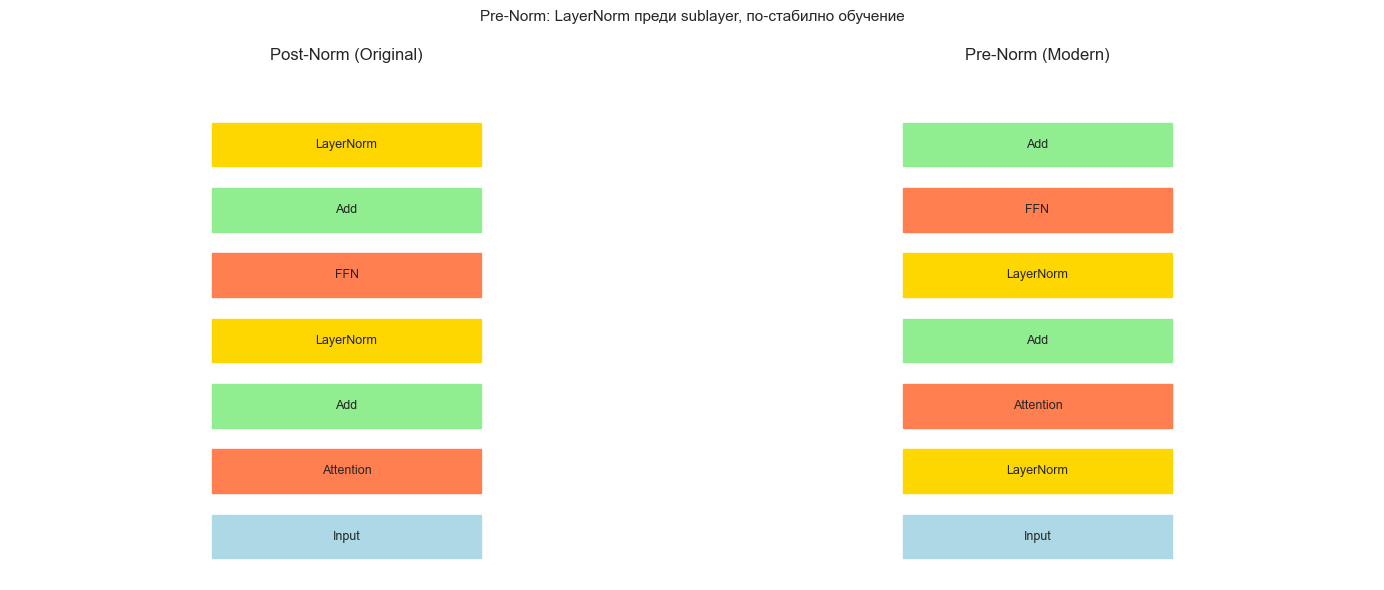

In [8]:
# Визуализация на Pre-Norm vs Post-Norm
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Post-Norm
ax = axes[0]
blocks = [
    ('Input', 0, 'lightblue'),
    ('Attention', 1, 'coral'),
    ('Add', 2, 'lightgreen'),
    ('LayerNorm', 3, 'gold'),
    ('FFN', 4, 'coral'),
    ('Add', 5, 'lightgreen'),
    ('LayerNorm', 6, 'gold'),
]
for name, i, color in blocks:
    ax.add_patch(plt.Rectangle((0.3, i*0.6), 0.4, 0.4, fill=True, color=color))
    ax.text(0.5, i*0.6 + 0.2, name, ha='center', va='center', fontsize=9)
ax.set_xlim(0, 1); ax.set_ylim(-0.2, 4.5)
ax.axis('off')
ax.set_title('Post-Norm (Original)', fontsize=12)

# Pre-Norm
ax = axes[1]
blocks = [
    ('Input', 0, 'lightblue'),
    ('LayerNorm', 1, 'gold'),
    ('Attention', 2, 'coral'),
    ('Add', 3, 'lightgreen'),
    ('LayerNorm', 4, 'gold'),
    ('FFN', 5, 'coral'),
    ('Add', 6, 'lightgreen'),
]
for name, i, color in blocks:
    ax.add_patch(plt.Rectangle((0.3, i*0.6), 0.4, 0.4, fill=True, color=color))
    ax.text(0.5, i*0.6 + 0.2, name, ha='center', va='center', fontsize=9)
ax.set_xlim(0, 1); ax.set_ylim(-0.2, 4.5)
ax.axis('off')
ax.set_title('Pre-Norm (Modern)', fontsize=12)

plt.suptitle('Pre-Norm: LayerNorm преди sublayer, по-стабилно обучение', fontsize=11)
plt.tight_layout()
plt.show()

### RMSNorm: Още по-просто

Използва се от LLaMA, Mistral:

$$\text{RMSNorm}(x) = \frac{x}{\sqrt{\frac{1}{d}\sum_i x_i^2 + \epsilon}} \cdot \gamma$$

**Предимство:** Без изваждане на средното → по-бързо.

In [9]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps
    
    def forward(self, x):
        rms = torch.sqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x / rms * self.weight

# Тест
rms_norm = RMSNorm(64)
x = torch.randn(2, 10, 64)
print(f"RMSNorm: {x.shape} → {rms_norm(x).shape}")

RMSNorm: torch.Size([2, 10, 64]) → torch.Size([2, 10, 64])


### Пълен Transformer блок

In [10]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention (от Лекция 4)."""
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.W_o(context), attn_weights

In [11]:
class TransformerBlock(nn.Module):
    """Пълен Transformer блок (Pre-Norm)."""
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Attention sublayer
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        
        # FFN sublayer
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Pre-norm: LayerNorm → Sublayer → Add
        
        # Attention sublayer
        normed = self.norm1(x)
        attn_out, attn_weights = self.attention(normed, mask)
        x = x + self.dropout(attn_out)  # Residual
        
        # FFN sublayer
        normed = self.norm2(x)
        ffn_out = self.ffn(normed)
        x = x + self.dropout(ffn_out)   # Residual
        
        return x, attn_weights

# Тест
block = TransformerBlock(d_model=64, n_heads=8, d_ff=256)
x = torch.randn(2, 10, 64)
out, weights = block(x)

print(f"Input: {x.shape}")
print(f"Output: {out.shape}")
print(f"Attention weights: {weights.shape}")

Input: torch.Size([2, 10, 64])
Output: torch.Size([2, 10, 64])
Attention weights: torch.Size([2, 8, 10, 10])


### Размерности през блока

In [12]:
# Проследяване на размерностите
batch, seq_len, d_model = 2, 10, 64
n_heads, d_ff = 8, 256

print("Размерности през Transformer блок:")
print(f"")
print(f"Input:           [{batch}, {seq_len}, {d_model}]")
print(f"↓ LayerNorm:     [{batch}, {seq_len}, {d_model}]")
print(f"↓ Q, K, V proj:  [{batch}, {seq_len}, {d_model}] → split heads")
print(f"↓ Per head:      [{batch}, {n_heads}, {seq_len}, {d_model//n_heads}]")
print(f"↓ Attention:     [{batch}, {n_heads}, {seq_len}, {seq_len}] (weights)")
print(f"↓ Context:       [{batch}, {n_heads}, {seq_len}, {d_model//n_heads}]")
print(f"↓ Concat heads:  [{batch}, {seq_len}, {d_model}]")
print(f"↓ + Residual:    [{batch}, {seq_len}, {d_model}]")
print(f"↓ LayerNorm:     [{batch}, {seq_len}, {d_model}]")
print(f"↓ FFN up:        [{batch}, {seq_len}, {d_ff}]")
print(f"↓ FFN down:      [{batch}, {seq_len}, {d_model}]")
print(f"↓ + Residual:    [{batch}, {seq_len}, {d_model}]")
print(f"Output:          [{batch}, {seq_len}, {d_model}]")

Размерности през Transformer блок:

Input:           [2, 10, 64]
↓ LayerNorm:     [2, 10, 64]
↓ Q, K, V proj:  [2, 10, 64] → split heads
↓ Per head:      [2, 8, 10, 8]
↓ Attention:     [2, 8, 10, 10] (weights)
↓ Context:       [2, 8, 10, 8]
↓ Concat heads:  [2, 10, 64]
↓ + Residual:    [2, 10, 64]
↓ LayerNorm:     [2, 10, 64]
↓ FFN up:        [2, 10, 256]
↓ FFN down:      [2, 10, 64]
↓ + Residual:    [2, 10, 64]
Output:          [2, 10, 64]


---
## 3. Стекване на слоеве

### Дълбока Transformer архитектура

Стекваме N идентични блока:

| Модел | Слоеве | $d_{model}$ | Heads | Параметри |
|-------|--------|-------------|-------|-----------|
| BERT-base | 12 | 768 | 12 | 110M |
| GPT-2 | 12-48 | 768-1600 | 12-25 | 124M-1.5B |
| GPT-3 | 96 | 12288 | 96 | 175B |
| LLaMA 70B | 80 | 8192 | 64 | 70B |


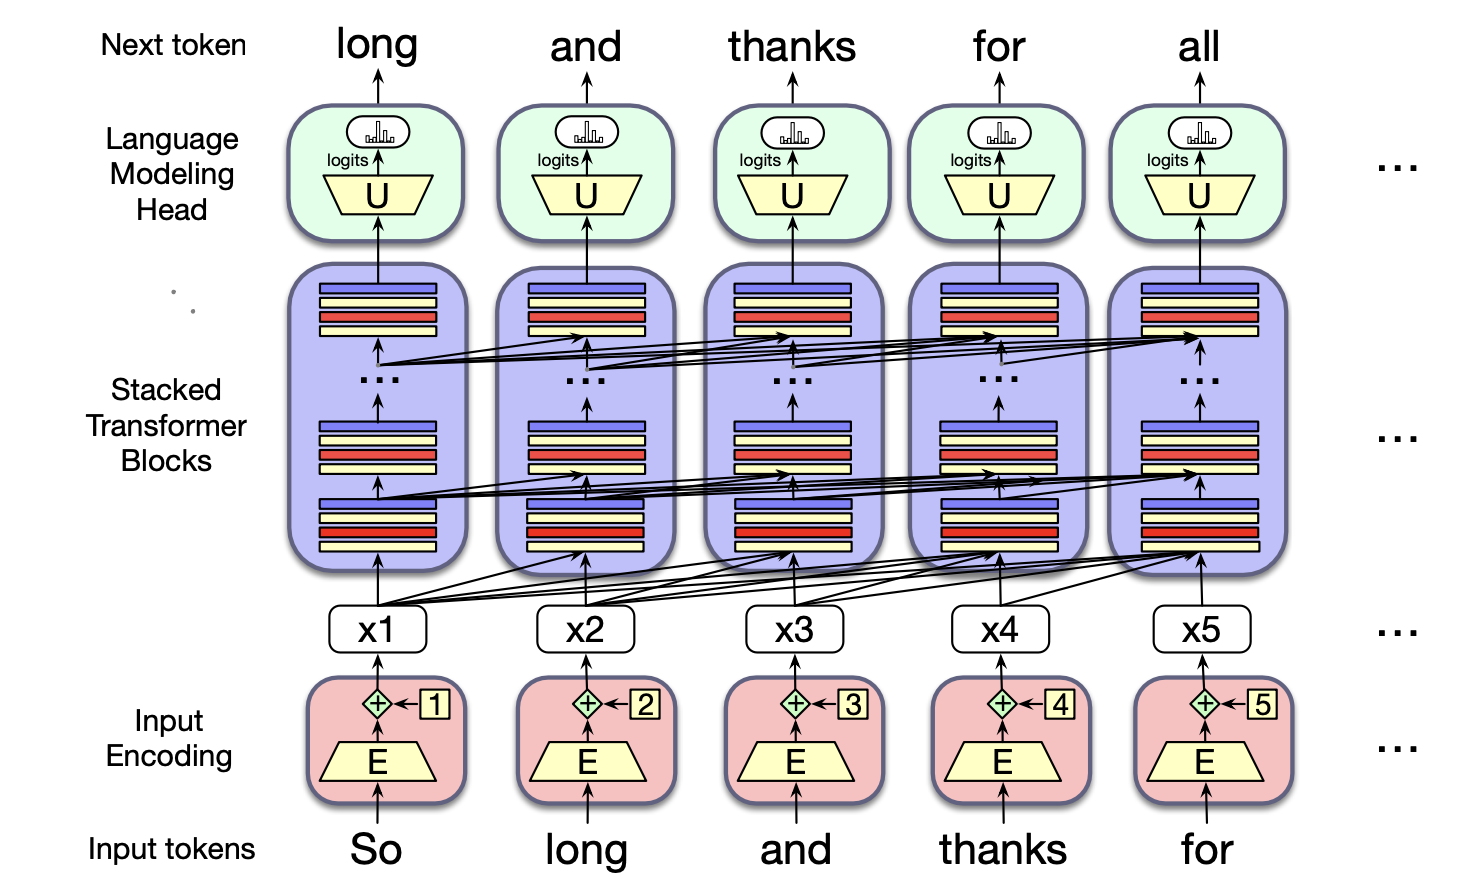

In [13]:
class Transformer(nn.Module):
    """Пълен Transformer (Decoder-only)."""
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, 
                 max_seq_len, dropout=0.1):
        super().__init__()
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.ln_f = nn.LayerNorm(d_model)
        
        # Output projection
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        
        self.d_model = d_model
    
    def forward(self, idx, mask=None):
        batch, seq_len = idx.shape
        
        # Embeddings
        tok_emb = self.token_embedding(idx)
        pos_emb = self.pos_embedding(torch.arange(seq_len, device=idx.device))
        x = tok_emb + pos_emb
        
        # Transformer blocks
        for block in self.blocks:
            x, _ = block(x, mask)
        
        # Output
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits

# GPT-2-like модел (малък)
model = Transformer(
    vocab_size=50257,
    d_model=768,
    n_layers=12,
    n_heads=12,
    d_ff=3072,
    max_seq_len=1024,
    dropout=0.1
)

# Брой параметри
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,} (~{total_params/1e6:.0f}M)")

Total parameters: 163,037,184 (~163M)


### Какво научават различните слоеве?

Изследвания показват специализация:

| Слоеве | Научени features |
|--------|------------------|
| **Ранни** (1-4) | Синтаксис, локални зависимости, POS-like |
| **Средни** (5-8) | Семантика на фразово ниво, coreference |
| **Късни** (9-12) | Task-specific, високо абстрактни |

### Скалиране на параметри

Всеки блок добавя:
- **Attention:** $4 \times d_{model}^2$ (Q, K, V, O проекции)
- **FFN:** $8 \times d_{model}^2$ (при 4x expansion)
- **Общо на блок:** ~$12 \times d_{model}^2$

In [14]:
# Анализ на параметри по компонент
d_model = 768
n_layers = 12
vocab_size = 50257

# Per block
attn_params = 4 * d_model * d_model  # W_q, W_k, W_v, W_o
ffn_params = 2 * d_model * (4 * d_model)  # W1, W2
ln_params = 2 * 2 * d_model  # 2 layer norms, gamma + beta

block_params = attn_params + ffn_params + ln_params
all_blocks = block_params * n_layers

# Embeddings
embed_params = vocab_size * d_model + 1024 * d_model  # token + position

# Output head (tied with embeddings in some models)
head_params = vocab_size * d_model

print("GPT-2 (124M) параметри:")
print(f"  Per attention: {attn_params:,}")
print(f"  Per FFN: {ffn_params:,}")
print(f"  Per block: {block_params:,}")
print(f"  All blocks ({n_layers}): {all_blocks:,}")
print(f"  Embeddings: {embed_params:,}")
print(f"  Output head: {head_params:,}")
print(f"  Total: {all_blocks + embed_params + head_params:,}")

GPT-2 (124M) параметри:
  Per attention: 2,359,296
  Per FFN: 4,718,592
  Per block: 7,080,960
  All blocks (12): 84,971,520
  Embeddings: 39,383,808
  Output head: 38,597,376
  Total: 162,952,704


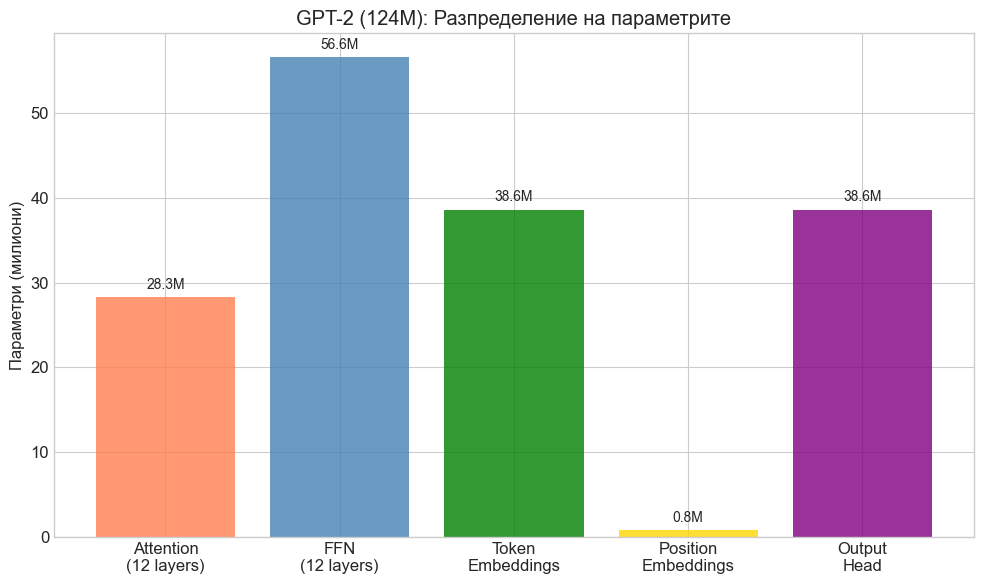

FFN е най-големият компонент (35%)!


In [15]:
# Визуализация на параметри по компонент
fig, ax = plt.subplots(figsize=(10, 6))

components = ['Attention\n(12 layers)', 'FFN\n(12 layers)', 'Token\nEmbeddings', 
              'Position\nEmbeddings', 'Output\nHead']
params = [attn_params * n_layers, ffn_params * n_layers, 
          vocab_size * d_model, 1024 * d_model, head_params]
colors = ['coral', 'steelblue', 'green', 'gold', 'purple']

bars = ax.bar(components, [p/1e6 for p in params], color=colors, alpha=0.8)
ax.set_ylabel('Параметри (милиони)')
ax.set_title('GPT-2 (124M): Разпределение на параметрите')

for bar, p in zip(bars, params):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{p/1e6:.1f}M', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"FFN е най-големият компонент ({ffn_params * n_layers / (all_blocks + embed_params + head_params) * 100:.0f}%)!")

---
## 4. Encoder vs Decoder архитектури

### Три основни варианта

| Архитектура | Attention | Примери | Задачи |
|-------------|-----------|---------|--------|
| **Encoder-only** | Bidirectional | BERT, RoBERTa | Classification, NER |
| **Decoder-only** | Causal | GPT, LLaMA | Generation |
| **Encoder-Decoder** | Both + Cross | T5, BART | Translation, Summarization |

### Encoder-Only (BERT)

**Bidirectional attention:** Всяка позиция вижда всички други.

```
The cat [MASK] on mat
 ↓   ↓    ↓    ↓   ↓
All ←→ positions ←→ connected
```

**Предимство:** Пълен контекст за всяка позиция.  
**Недостатък:** Не може да генерира текст директно.

### Decoder-Only (GPT, LLaMA)

**Causal attention:** Позиция i вижда само позиции ≤ i.

```
The cat sat on mat
 ↓   ↓   ↓   ↓   ↓
 1 → 2 → 3 → 4 → 5
```

**Доминира в модерните LLM!**

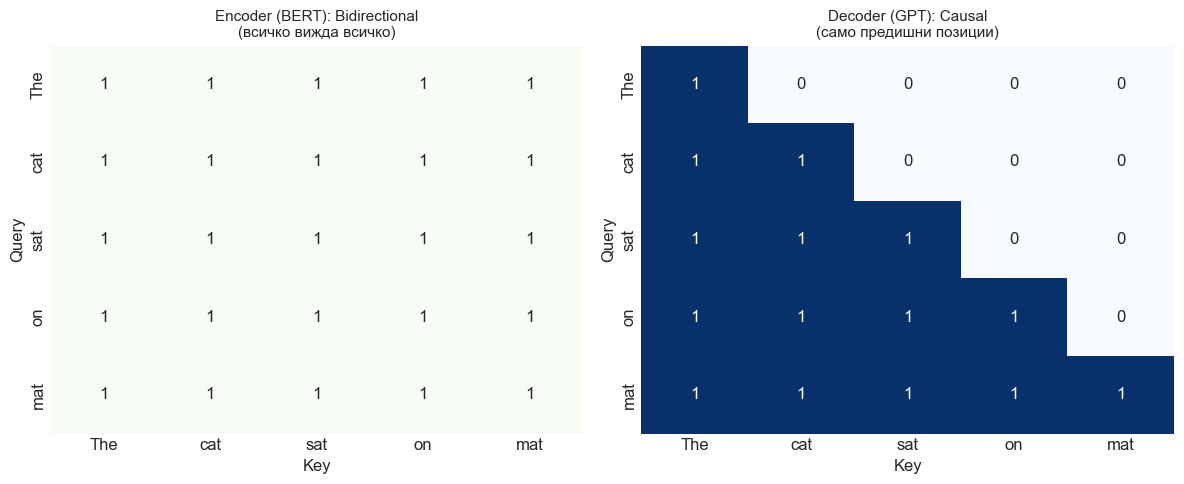

In [16]:
# Визуализация: Bidirectional vs Causal attention
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

tokens = ['The', 'cat', 'sat', 'on', 'mat']
n = len(tokens)

# Bidirectional (BERT)
ax = axes[0]
mask_bidir = np.ones((n, n))
sns.heatmap(mask_bidir, annot=True, fmt='.0f', cmap='Greens',
            xticklabels=tokens, yticklabels=tokens, ax=ax, cbar=False)
ax.set_title('Encoder (BERT): Bidirectional\n(всичко вижда всичко)', fontsize=11)
ax.set_xlabel('Key'); ax.set_ylabel('Query')

# Causal (GPT)
ax = axes[1]
mask_causal = np.tril(np.ones((n, n)))
sns.heatmap(mask_causal, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=tokens, yticklabels=tokens, ax=ax, cbar=False)
ax.set_title('Decoder (GPT): Causal\n(само предишни позиции)', fontsize=11)
ax.set_xlabel('Key'); ax.set_ylabel('Query')

plt.tight_layout()
plt.show()

### Защо Decoder-only доминира?

| Причина | Обяснение |
|---------|-----------|
| **По-проста архитектура** | Един тип attention |
| **Natural за генерация** | Next-token prediction |
| **Unified approach** | Всички задачи като text generation |
| **По-добро scaling** | Емпирично доказано |

### Encoder-Decoder (T5, BART)

```
Encoder                    Decoder
  ↓                          ↓
Bidirectional    →    Causal + Cross-attention
  ↓                          ↓
Input representation    Output generation
```

**Cross-attention:** Decoder "пита" encoder outputs.

**По-малко популярен днес:** Decoder-only може същите задачи.

---
## 5. Модерни Attention варианти

### Проблемът с ефективността

Standard Multi-Head Attention:
- **Памет за weights:** O(n²) за всеки head
- **Compute:** O(n²d)

**При дълъг контекст:** Памет и compute експлодират!

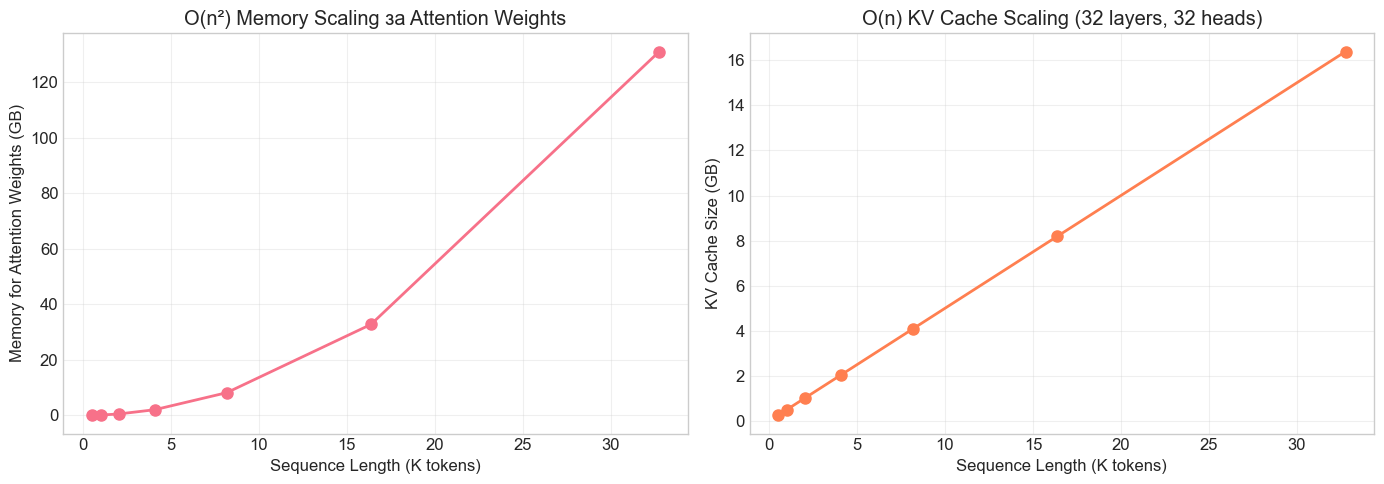

При 32K tokens: 131.1 GB само за attention weights!


In [17]:
# O(n²) scaling
seq_lengths = np.array([512, 1024, 2048, 4096, 8192, 16384, 32768])
n_heads = 32
d_k = 64

# Памет за attention weights: n² * n_heads * 4 bytes (float32)
memory_weights_mb = (seq_lengths ** 2 * n_heads * 4) / (1024 ** 2)

# KV cache памет: 2 * n_heads * seq_len * d_k * n_layers * 4 bytes
n_layers = 32
kv_cache_mb = (2 * n_heads * seq_lengths * d_k * n_layers * 4) / (1024 ** 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(seq_lengths / 1000, memory_weights_mb / 1000, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Sequence Length (K tokens)')
ax.set_ylabel('Memory for Attention Weights (GB)')
ax.set_title('O(n²) Memory Scaling за Attention Weights')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(seq_lengths / 1000, kv_cache_mb / 1000, 'o-', linewidth=2, markersize=8, color='coral')
ax.set_xlabel('Sequence Length (K tokens)')
ax.set_ylabel('KV Cache Size (GB)')
ax.set_title('O(n) KV Cache Scaling (32 layers, 32 heads)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"При 32K tokens: {memory_weights_mb[-1]/1000:.1f} GB само за attention weights!")

### Multi-Query Attention (MQA)

**Идея:** Споделяме K, V между всички heads, само Q е per-head.

| Компонент | Standard MHA | MQA |
|-----------|--------------|-----|
| Q projections | h | h |
| K projections | h | **1** |
| V projections | h | **1** |
| KV cache | $2 \times h \times n \times d_k$ | $2 \times n \times d_k$ |

In [18]:
class MultiQueryAttention(nn.Module):
    """Multi-Query Attention: Shared K, V across heads."""
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Separate Q for each head
        self.W_q = nn.Linear(d_model, d_model)  # d_model = n_heads * d_k
        
        # SHARED K, V (single head dimension)
        self.W_k = nn.Linear(d_model, self.d_k)  # Only d_k, not d_model!
        self.W_v = nn.Linear(d_model, self.d_k)
        
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Q: [batch, seq, n_heads, d_k]
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k)
        Q = Q.transpose(1, 2)  # [batch, n_heads, seq, d_k]
        
        # K, V: [batch, seq, d_k] - SHARED!
        K = self.W_k(x)  # [batch, seq, d_k]
        V = self.W_v(x)
        
        # Expand K, V to match heads: [batch, 1, seq, d_k] → broadcast
        K = K.unsqueeze(1)  # [batch, 1, seq, d_k]
        V = V.unsqueeze(1)
        
        # Attention (K, V broadcast across heads)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.W_o(context), attn_weights

# Сравнение на параметри
mha = MultiHeadAttention(d_model=512, n_heads=8)
mqa = MultiQueryAttention(d_model=512, n_heads=8)

mha_params = sum(p.numel() for p in mha.parameters())
mqa_params = sum(p.numel() for p in mqa.parameters())

print(f"MHA parameters: {mha_params:,}")
print(f"MQA parameters: {mqa_params:,}")
print(f"MQA reduction: {(1 - mqa_params/mha_params)*100:.1f}%")

MHA parameters: 1,050,624
MQA parameters: 590,976
MQA reduction: 43.8%


### Grouped-Query Attention (GQA)

**Компромис:** Групи от heads споделят K, V.

**Пример:** 32 query heads, 8 KV heads → всеки 4 Q heads споделят K, V.

| Вариант | Query heads | KV heads | KV cache размер |
|---------|-------------|----------|----------------|
| MHA | 32 | 32 | 32x |
| GQA | 32 | 8 | 8x |
| MQA | 32 | 1 | 1x |

In [19]:
class GroupedQueryAttention(nn.Module):
    """Grouped-Query Attention: Groups of Q heads share K, V."""
    def __init__(self, d_model, n_heads, n_kv_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        assert n_heads % n_kv_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_heads // n_kv_heads  # How many Q heads per KV head
        self.d_k = d_model // n_heads
        
        # Q: full heads
        self.W_q = nn.Linear(d_model, n_heads * self.d_k)
        
        # K, V: fewer heads
        self.W_k = nn.Linear(d_model, n_kv_heads * self.d_k)
        self.W_v = nn.Linear(d_model, n_kv_heads * self.d_k)
        
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Q: [batch, seq, n_heads, d_k]
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k)
        Q = Q.transpose(1, 2)  # [batch, n_heads, seq, d_k]
        
        # K, V: [batch, seq, n_kv_heads, d_k]
        K = self.W_k(x).view(batch_size, seq_len, self.n_kv_heads, self.d_k)
        V = self.W_v(x).view(batch_size, seq_len, self.n_kv_heads, self.d_k)
        K = K.transpose(1, 2)  # [batch, n_kv_heads, seq, d_k]
        V = V.transpose(1, 2)
        
        # Repeat K, V for each group
        # [batch, n_kv_heads, seq, d_k] → [batch, n_heads, seq, d_k]
        K = K.repeat_interleave(self.n_rep, dim=1)
        V = V.repeat_interleave(self.n_rep, dim=1)
        
        # Standard attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.W_o(context), attn_weights

# LLaMA 2 style: 32 query heads, 8 KV heads
gqa = GroupedQueryAttention(d_model=512, n_heads=32, n_kv_heads=8)

x = torch.randn(2, 10, 512)
out, weights = gqa(x)

print(f"GQA: {x.shape} → {out.shape}")
print(f"Attention weights: {weights.shape}")

GQA: torch.Size([2, 10, 512]) → torch.Size([2, 10, 512])
Attention weights: torch.Size([2, 32, 10, 10])


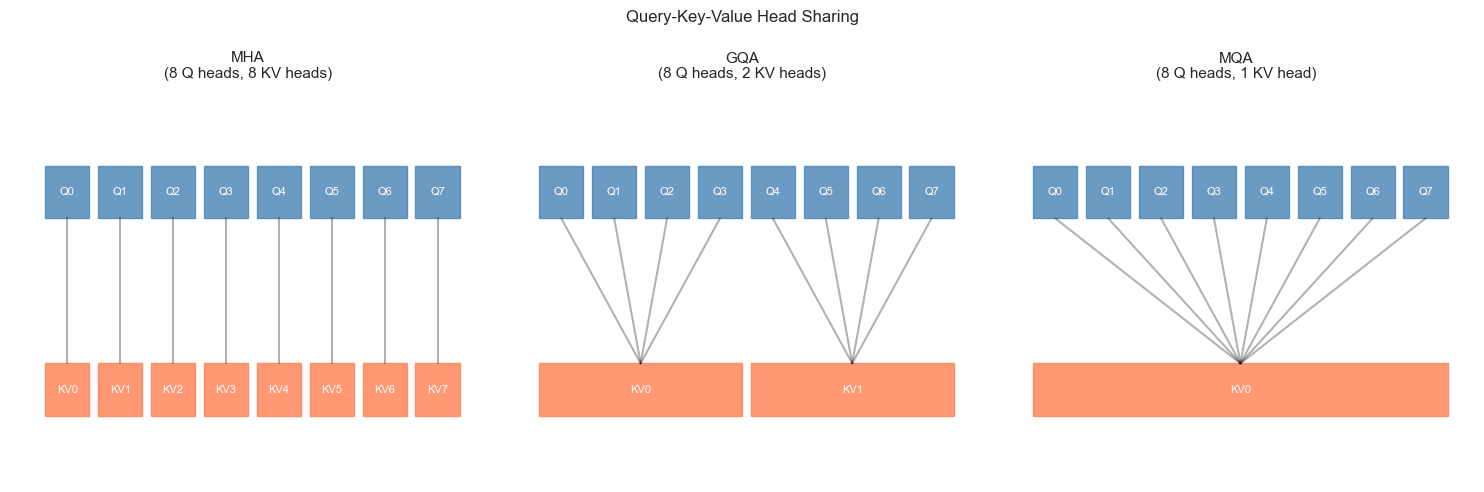

In [20]:
# Визуализация: MHA vs GQA vs MQA
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def draw_heads(ax, n_q, n_kv, title):
    # Draw Q heads
    for i in range(n_q):
        ax.add_patch(plt.Rectangle((i*0.3, 2), 0.25, 0.4, 
                                   fill=True, color='steelblue', alpha=0.8))
        ax.text(i*0.3 + 0.125, 2.2, f'Q{i}', ha='center', va='center', 
                fontsize=8, color='white')
    
    # Draw KV heads
    kv_width = n_q * 0.3 / n_kv
    for i in range(n_kv):
        ax.add_patch(plt.Rectangle((i*kv_width, 0.5), kv_width - 0.05, 0.4, 
                                   fill=True, color='coral', alpha=0.8))
        ax.text(i*kv_width + kv_width/2 - 0.025, 0.7, f'KV{i}', 
                ha='center', va='center', fontsize=8, color='white')
    
    # Draw connections
    for qi in range(n_q):
        kvi = qi * n_kv // n_q
        ax.plot([qi*0.3 + 0.125, kvi*kv_width + kv_width/2 - 0.025], 
                [2, 0.9], 'k-', alpha=0.3)
    
    ax.set_xlim(-0.2, n_q * 0.3 + 0.1)
    ax.set_ylim(0, 3)
    ax.axis('off')
    ax.set_title(title, fontsize=11)

draw_heads(axes[0], 8, 8, 'MHA\n(8 Q heads, 8 KV heads)')
draw_heads(axes[1], 8, 2, 'GQA\n(8 Q heads, 2 KV heads)')
draw_heads(axes[2], 8, 1, 'MQA\n(8 Q heads, 1 KV head)')

plt.suptitle('Query-Key-Value Head Sharing', fontsize=12)
plt.tight_layout()
plt.show()

### Flash Attention

**Проблемът:** Standard attention изисква O(n²) памет.

**Flash Attention идея:**
- Не материализираме пълната attention матрица
- Изчисляваме на блокове (tiles) в бърза SRAM памет
- **O(n²) compute, O(n) memory!**

### GPU Memory Hierarchy

```
SRAM (on-chip):    ~20 MB, ~19 TB/s
HBM (GPU memory):  ~40 GB, ~1.5 TB/s
```

**Memory bandwidth е bottleneck**, не compute!

Flash Attention:
- Load Q, K, V на блокове в SRAM
- Compute attention локално
- Accumulate outputs
- Never store full n×n matrix

In [21]:
# Pseudo-code за Flash Attention (концептуално)
def flash_attention_pseudocode(Q, K, V, block_size=64):
    """
    Flash Attention алгоритъм (опростен).
    
    Реалната имплементация е в CUDA и много по-сложна.
    """
    seq_len, d = Q.shape
    output = np.zeros_like(Q)
    
    # Process in blocks
    for i in range(0, seq_len, block_size):
        q_block = Q[i:i+block_size]  # Load Q block to SRAM
        
        # Running statistics for softmax
        max_score = -np.inf
        sum_exp = 0
        acc = np.zeros((block_size, d))
        
        for j in range(0, seq_len, block_size):
            k_block = K[j:j+block_size]  # Load K block
            v_block = V[j:j+block_size]  # Load V block
            
            # Compute attention scores (in SRAM)
            scores = q_block @ k_block.T / np.sqrt(d)
            
            # Online softmax update
            # ... complex math to maintain running max/sum ...
            
            # Accumulate output
            # acc += softmax(scores) @ v_block
        
        output[i:i+block_size] = acc  # Write back to HBM
    
    return output

print("Flash Attention:")
print("  - 2-4x speedup in practice")
print("  - O(n²) compute, O(n) memory")
print("  - Standard за всички модерни LLM")

Flash Attention:
  - 2-4x speedup in practice
  - O(n²) compute, O(n) memory
  - Standard за всички модерни LLM


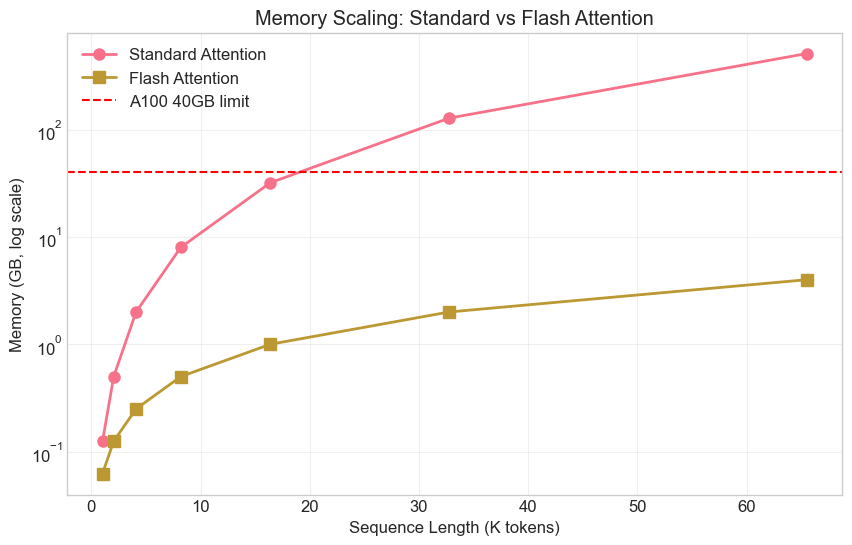

При 64K tokens:
  Standard: 512 GB (невъзможно!)
  Flash: 4.0 GB


In [22]:
# Сравнение на memory: Standard vs Flash
seq_lengths = np.array([1024, 2048, 4096, 8192, 16384, 32768, 65536])
d_model = 4096
n_heads = 32

# Standard: store full n×n attention matrix
standard_memory_gb = (seq_lengths ** 2 * n_heads * 4) / (1024 ** 3)

# Flash: only store O(n) intermediate results
flash_memory_gb = (seq_lengths * d_model * 4 * 4) / (1024 ** 3)  # ~4x for intermediates

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogy(seq_lengths / 1000, standard_memory_gb, 'o-', 
            label='Standard Attention', linewidth=2, markersize=8)
ax.semilogy(seq_lengths / 1000, flash_memory_gb, 's-', 
            label='Flash Attention', linewidth=2, markersize=8)
ax.axhline(y=40, color='red', linestyle='--', label='A100 40GB limit')

ax.set_xlabel('Sequence Length (K tokens)')
ax.set_ylabel('Memory (GB, log scale)')
ax.set_title('Memory Scaling: Standard vs Flash Attention')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"При 64K tokens:")
print(f"  Standard: {standard_memory_gb[-1]:.0f} GB (невъзможно!)")
print(f"  Flash: {flash_memory_gb[-1]:.1f} GB")

---
## 6. Long Context: От 512 до 1M+ токена

### Еволюция на context length

| Модел | Година | Context |
|-------|--------|--------|
| Original Transformer | 2017 | 512 |
| GPT-2 | 2019 | 1,024 |
| GPT-3 | 2020 | 2,048 |
| GPT-4 | 2023 | 8K-128K |
| Claude 3 | 2024 | 200K |
| Gemini 1.5 | 2024 | 1M+ |

### Защо дълъг контекст е важен?

- **Дълги документи:** Книги, правни текстове, код
- **Повече примери:** In-context learning с много shots
- **Сложно reasoning:** Multi-step задачи
- **Code repositories:** Цели проекти в контекста

### Проблемът с позициите

**Learned positional embeddings:**
- Фиксиран максимум $L_{max}$
- Не генерализира отвъд training length

**Sinusoidal:**
- Теоретично unlimited
- На практика лоша екстраполация

### Rotary Position Embeddings (RoPE)

**Идея:** Кодираме позицията чрез ротация на Q, K векторите.

$$\text{Attention}(R_{pos_q} \cdot q, R_{pos_k} \cdot k, v)$$

Където $R_{pos}$ е ротационна матрица.

**Ключово свойство:** $q^T R_{pos_q}^T R_{pos_k} k$ зависи от $pos_q - pos_k$!

### RoPE: Интуиция

- Всяка двойка измерения се завърта на различен ъгъл
- Ъгълът зависи от позицията
- Dot product "вижда" относителната позиция

**Предимства:**
- По-добра екстраполация от learned/sinusoidal
- Ефективно изчисление
- **Използва се от:** LLaMA, Mistral, повечето модерни модели

In [23]:
def precompute_rope_freqs(dim, max_seq_len, base=10000):
    """Precompute RoPE frequencies."""
    # Frequencies for each dimension pair
    freqs = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
    
    # Position indices
    t = torch.arange(max_seq_len)
    
    # Outer product: [seq_len, dim//2]
    freqs = torch.outer(t, freqs)
    
    # Complex exponential: e^(i*theta) = cos(theta) + i*sin(theta)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    
    return freqs_cis

def apply_rope(x, freqs_cis):
    """Apply RoPE to input tensor."""
    # x: [batch, seq_len, n_heads, d_k]
    # Reshape to complex: [batch, seq_len, n_heads, d_k//2, 2] → complex
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    
    # Apply rotation
    freqs_cis = freqs_cis[:x.shape[1], :].unsqueeze(0).unsqueeze(2)  # [1, seq, 1, d_k//2]
    x_rotated = x_complex * freqs_cis
    
    # Back to real
    return torch.view_as_real(x_rotated).flatten(-2).type_as(x)

# Demo
d_k = 64
freqs = precompute_rope_freqs(d_k, max_seq_len=1000)
print(f"RoPE frequencies shape: {freqs.shape}")

x = torch.randn(2, 10, 8, d_k)  # [batch, seq, heads, d_k]
x_rotated = apply_rope(x, freqs)
print(f"Input: {x.shape} → Rotated: {x_rotated.shape}")

RoPE frequencies shape: torch.Size([1000, 32])
Input: torch.Size([2, 10, 8, 64]) → Rotated: torch.Size([2, 10, 8, 64])


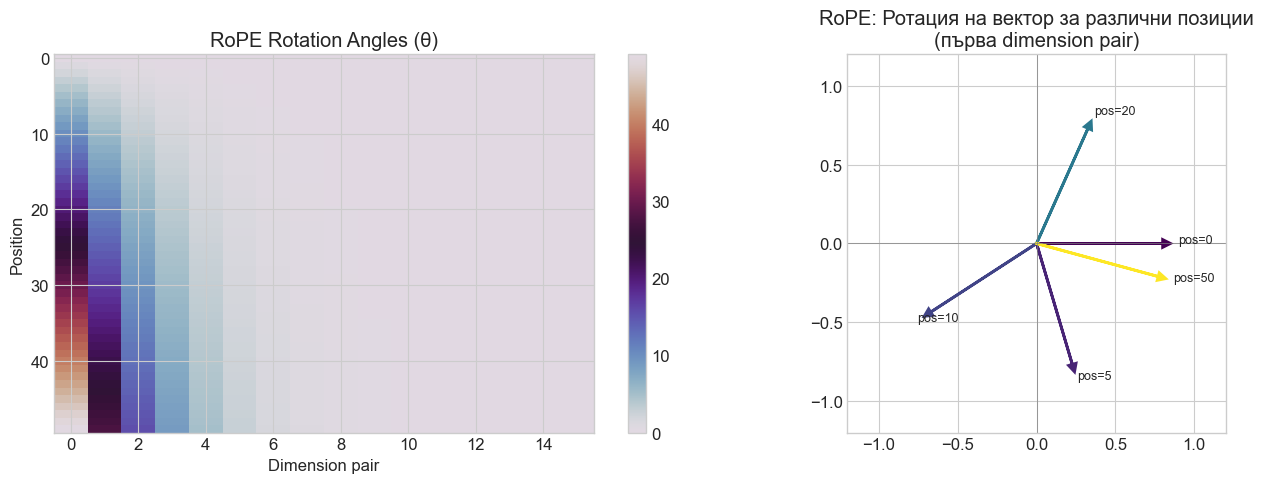

In [24]:
# Визуализация на RoPE ротации
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rotation angles за различни позиции и измерения
d_k = 32
positions = torch.arange(100)
base = 10000
freqs = 1.0 / (base ** (torch.arange(0, d_k, 2).float() / d_k))
angles = torch.outer(positions, freqs).numpy()

ax = axes[0]
im = ax.imshow(angles[:50, :], aspect='auto', cmap='twilight')
ax.set_xlabel('Dimension pair')
ax.set_ylabel('Position')
ax.set_title('RoPE Rotation Angles (θ)')
plt.colorbar(im, ax=ax)

# 2D rotation visualization
ax = axes[1]
# Show how a 2D vector rotates with position
for pos in [0, 5, 10, 20, 50]:
    theta = pos * freqs[0].item()  # First frequency
    x = np.cos(theta)
    y = np.sin(theta)
    ax.arrow(0, 0, x*0.8, y*0.8, head_width=0.05, head_length=0.05, 
             fc=plt.cm.viridis(pos/50), ec=plt.cm.viridis(pos/50), linewidth=2)
    ax.text(x*0.9, y*0.9, f'pos={pos}', fontsize=9)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_title('RoPE: Ротация на вектор за различни позиции\n(първа dimension pair)')

plt.tight_layout()
plt.show()

### Position Interpolation

**Проблем:** Модел обучен на 4K, искаме 32K.

**Решение:** Скалираме позициите:

$$pos' = pos \times \frac{L_{train}}{L_{target}}$$

32K позиции се "свиват" в 4K.

**Изисква:** Кратък fine-tuning на дълги примери.

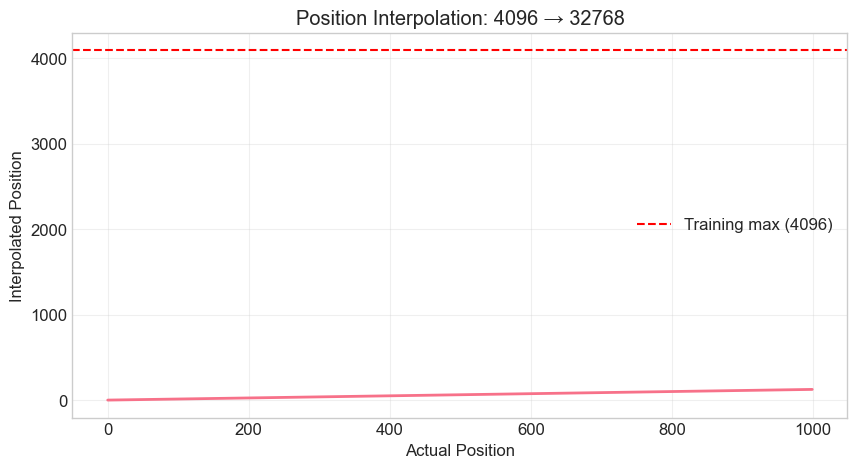

Scale factor: 0.1250
Position 32000 → 4000 (within training range)


In [25]:
# Position interpolation demo
L_train = 4096
L_target = 32768
scale = L_train / L_target

# Original positions
positions_original = np.arange(L_target)

# Interpolated positions
positions_interpolated = positions_original * scale

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(positions_original[:1000], positions_interpolated[:1000], linewidth=2)
ax.axhline(y=L_train, color='red', linestyle='--', label=f'Training max ({L_train})')
ax.set_xlabel('Actual Position')
ax.set_ylabel('Interpolated Position')
ax.set_title(f'Position Interpolation: {L_train} → {L_target}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print(f"Scale factor: {scale:.4f}")
print(f"Position 32000 → {32000 * scale:.0f} (within training range)")

### YaRN и NTK-aware Scaling

**YaRN (Yet another RoPE extensioN):**
- Различно scaling за различни честоти
- По-добра дългосрочна performance

**NTK-aware:**
- Модифицира base frequency в RoPE
- Работи zero-shot (без fine-tuning)
- Известна загуба на качество

### Sliding Window Attention

**Идея:** Всеки токен attend-ва само към локален прозорец.

```
Token i attends to: [i-w, i-w+1, ..., i-1, i]
```

- **Сложност:** O(n × w) вместо O(n²)
- **Дълги зависимости:** Информация се пренася през слоевете

**Използва се от:** Mistral, Longformer

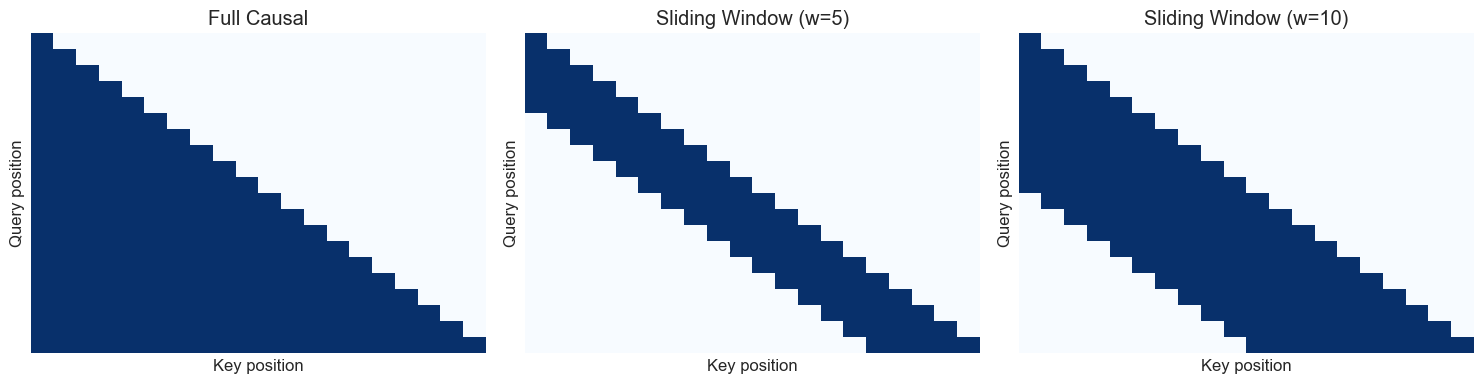

Sliding window: O(n·w) вместо O(n²)


In [26]:
# Sliding window attention mask
def create_sliding_window_mask(seq_len, window_size):
    """Create sliding window attention mask."""
    mask = torch.zeros(seq_len, seq_len)
    for i in range(seq_len):
        start = max(0, i - window_size + 1)
        mask[i, start:i+1] = 1
    return mask

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, mask) in zip(axes, [
    ('Full Causal', torch.tril(torch.ones(20, 20))),
    ('Sliding Window (w=5)', create_sliding_window_mask(20, 5)),
    ('Sliding Window (w=10)', create_sliding_window_mask(20, 10)),
]):
    sns.heatmap(mask.numpy(), cmap='Blues', cbar=False, ax=ax,
                xticklabels=False, yticklabels=False)
    ax.set_title(name)
    ax.set_xlabel('Key position')
    ax.set_ylabel('Query position')

plt.tight_layout()
plt.show()

print("Sliding window: O(n·w) вместо O(n²)")

### KV Cache: Ефективна генерация

**При генерация:** Всеки нов токен изисква attention към всички предишни.

**Без cache:** Преизчисляваме K, V за всички позиции на всяка стъпка.

**С KV cache:** Съхраняваме K, V за предишни позиции, изчисляваме само за новия токен.

In [27]:
class CachedAttention(nn.Module):
    """Attention с KV Cache за ефективна генерация."""
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, cache=None):
        """
        x: [batch, seq_len, d_model]
        cache: tuple (K_cache, V_cache) from previous steps
        """
        batch_size, seq_len, _ = x.shape
        
        # Compute Q, K, V for new tokens
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K_new = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V_new = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Append to cache
        if cache is not None:
            K_cache, V_cache = cache
            K = torch.cat([K_cache, K_new], dim=2)  # Concat along seq dimension
            V = torch.cat([V_cache, V_new], dim=2)
        else:
            K = K_new
            V = V_new
        
        # Standard attention with full K, V
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(context)
        
        # Return output and updated cache
        return output, (K, V)

# Demo: генерация токен по токен
attn = CachedAttention(d_model=64, n_heads=4)

# First token
x1 = torch.randn(1, 1, 64)
out1, cache = attn(x1, cache=None)
print(f"Step 1: input {x1.shape}, cache K shape: {cache[0].shape}")

# Second token
x2 = torch.randn(1, 1, 64)
out2, cache = attn(x2, cache=cache)
print(f"Step 2: input {x2.shape}, cache K shape: {cache[0].shape}")

# Third token
x3 = torch.randn(1, 1, 64)
out3, cache = attn(x3, cache=cache)
print(f"Step 3: input {x3.shape}, cache K shape: {cache[0].shape}")

Step 1: input torch.Size([1, 1, 64]), cache K shape: torch.Size([1, 4, 1, 16])
Step 2: input torch.Size([1, 1, 64]), cache K shape: torch.Size([1, 4, 2, 16])
Step 3: input torch.Size([1, 1, 64]), cache K shape: torch.Size([1, 4, 3, 16])


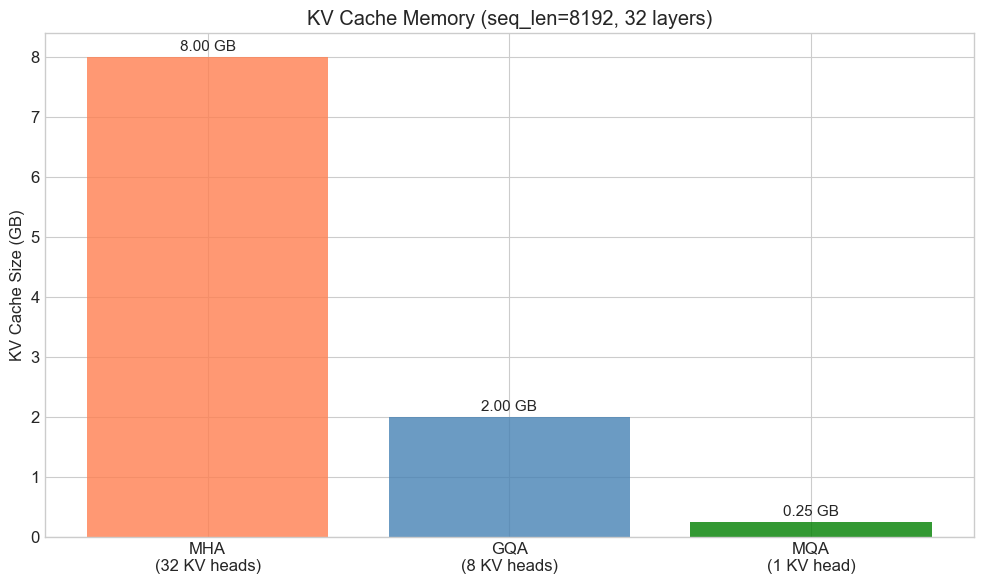

GQA спестява 75% KV cache памет!


In [28]:
# KV Cache размер: MHA vs GQA
seq_len = 8192
n_layers = 32
d_k = 128
n_heads = 32
n_kv_heads_gqa = 8

# KV cache: 2 (K and V) * layers * heads * seq * d_k * 4 bytes
mha_cache_gb = (2 * n_layers * n_heads * seq_len * d_k * 4) / (1024 ** 3)
gqa_cache_gb = (2 * n_layers * n_kv_heads_gqa * seq_len * d_k * 4) / (1024 ** 3)
mqa_cache_gb = (2 * n_layers * 1 * seq_len * d_k * 4) / (1024 ** 3)

fig, ax = plt.subplots(figsize=(10, 6))
variants = ['MHA\n(32 KV heads)', 'GQA\n(8 KV heads)', 'MQA\n(1 KV head)']
sizes = [mha_cache_gb, gqa_cache_gb, mqa_cache_gb]
colors = ['coral', 'steelblue', 'green']

bars = ax.bar(variants, sizes, color=colors, alpha=0.8)
ax.set_ylabel('KV Cache Size (GB)')
ax.set_title(f'KV Cache Memory (seq_len={seq_len}, {n_layers} layers)')

for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{size:.2f} GB', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

print(f"GQA спестява {(1 - gqa_cache_gb/mha_cache_gb)*100:.0f}% KV cache памет!")

### Ring Attention

**За много дълги последователности (1M+):**

- Разпределяме sequence между множество GPU
- Всеки GPU обработва chunk
- KV cache се предава "по ринг" между GPU

**Ограничение:** Общата памет на всички GPU

---
## 7. Цялостна архитектура

### Модерен LLM (2024 style)

**Типична конфигурация (LLaMA 3 70B):**

| Компонент | Стойност |
|-----------|----------|
| Слоеве | 80 |
| $d_{model}$ | 8192 |
| Query heads | 64 |
| KV heads | 8 (GQA) |
| FFN | SwiGLU, ~22K hidden |
| Normalization | RMSNorm (pre-norm) |
| Positions | RoPE |
| Context | 8K-128K |

In [29]:
# Сравнение на архитектури
models = {
    'GPT-2 (124M)': {'layers': 12, 'd_model': 768, 'heads': 12, 'kv_heads': 12, 'context': 1024},
    'LLaMA 7B': {'layers': 32, 'd_model': 4096, 'heads': 32, 'kv_heads': 32, 'context': 4096},
    'LLaMA 2 70B': {'layers': 80, 'd_model': 8192, 'heads': 64, 'kv_heads': 8, 'context': 4096},
    'Mistral 7B': {'layers': 32, 'd_model': 4096, 'heads': 32, 'kv_heads': 8, 'context': 32768},
}

print("Сравнение на модерни LLM архитектури:\n")
print(f"{'Model':<15} {'Layers':>7} {'d_model':>8} {'Q Heads':>8} {'KV Heads':>9} {'Context':>8}")
print("-" * 60)
for name, config in models.items():
    print(f"{name:<15} {config['layers']:>7} {config['d_model']:>8} {config['heads']:>8} "
          f"{config['kv_heads']:>9} {config['context']:>8}")

Сравнение на модерни LLM архитектури:

Model            Layers  d_model  Q Heads  KV Heads  Context
------------------------------------------------------------
GPT-2 (124M)         12      768       12        12     1024
LLaMA 7B             32     4096       32        32     4096
LLaMA 2 70B          80     8192       64         8     4096
Mistral 7B           32     4096       32         8    32768


In [30]:
# Пълна "production-ready" архитектура
class ModernTransformerBlock(nn.Module):
    """Modern Transformer block (LLaMA-style)."""
    def __init__(self, d_model, n_heads, n_kv_heads, d_ff):
        super().__init__()
        
        # RMSNorm instead of LayerNorm
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        
        # GQA instead of MHA
        self.attention = GroupedQueryAttention(d_model, n_heads, n_kv_heads)
        
        # SwiGLU instead of standard FFN
        self.ffn = SwiGLU(d_model, d_ff)
    
    def forward(self, x, mask=None):
        # Pre-norm with residual
        h = x + self.attention(self.norm1(x), mask)[0]
        out = h + self.ffn(self.norm2(h))
        return out

# LLaMA 2-style block
block = ModernTransformerBlock(
    d_model=4096, 
    n_heads=32, 
    n_kv_heads=8,  # GQA!
    d_ff=11008     # SwiGLU dimension
)

x = torch.randn(1, 10, 4096)
out = block(x)
print(f"Modern block: {x.shape} → {out.shape}")

params = sum(p.numel() for p in block.parameters())
print(f"Parameters per block: {params:,} (~{params/1e6:.0f}M)")

Modern block: torch.Size([1, 10, 4096]) → torch.Size([1, 10, 4096])
Parameters per block: 177,227,776 (~177M)


---
## 8. Обобщение и мост към следващата лекция

### Ключови изводи

1. **Transformer блок** = Attention + FFN + Residuals + LayerNorm
2. **Decoder-only** доминира в модерните LLM
3. **GQA/MQA** намаляват KV cache за ефективен inference
4. **Flash Attention** позволява по-дълги контексти
5. **RoPE + interpolation** разширяват контекста
6. **Модерни модели:** 100K-1M+ токена контекст

### Следваща лекция: Foundation Models и Pretraining Data

Архитектурата е готова. **Лекция 6** обхваща:

- Pretraining objectives: MLM vs autoregressive
- Data sources: Common Crawl, books, code
- Data quality: filtering, deduplication
- Scaling laws: оптимално съотношение model/data
- Contamination и evaluation integrity

---
## Ресурси

### Основни статии

1. **"Attention Is All You Need"** — Vaswani et al. (2017) — Original Transformer
2. **"Language Models are Few-Shot Learners"** — Brown et al. (2020) — GPT-3
3. **"LLaMA: Open and Efficient Foundation Language Models"** — Touvron et al. (2023)

### Efficiency Innovations

1. **"Fast Transformer Decoding: One Write-Head is All You Need"** — Shazeer (2019) — MQA
2. **"GQA: Training Generalized Multi-Query Transformer Models"** — Ainslie et al. (2023)
3. **"FlashAttention: Fast and Memory-Efficient Exact Attention"** — Dao et al. (2022)

### Long Context

1. **"RoFormer: Enhanced Transformer with Rotary Position Embedding"** — Su et al. (2021)
2. **"Extending Context Window via Positional Interpolation"** — Chen et al. (2023)
3. **"YaRN: Efficient Context Window Extension"** — Peng et al. (2023)

---
## Упражнения

### Упражнение 1: Пълен Transformer
- Имплементирайте пълен decoder-only transformer
- Обучете на малък dataset (Shakespeare, tiny stories)
- Генерирайте текст

### Упражнение 2: GQA имплементация
- Имплементирайте GQA от scratch
- Сравнете memory usage с MHA
- Benchmark inference speed

### Упражнение 3: RoPE exploration
- Имплементирайте RoPE
- Визуализирайте rotation patterns
- Тествайте extrapolation отвъд training length

### Упражнение 4: KV Cache
- Добавете KV caching към transformer
- Измерете speedup за генерация
- Profile memory usage

### Упражнение 5: Context Extension
- Вземете pre-trained модел (GPT-2)
- Приложете position interpolation
- Оценете perplexity на дълги последователности

---
## Край на Лекция 5

**Въпроси?**

---

**Следваща лекция:** Foundation Models и Pretraining Data